<a href="https://colab.research.google.com/github/naiksampan/Hello-World/blob/master/CV_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 1

#Plant seedling recognition
Classification process will consist of next steps:

1. Get data — reading of images and labels
2. Cleaning data — removing of image background, input normalization and label preparatin
3. Model — creating training and validation sets, creating and fitting model
4. Evaluate model — evaluation of model, make prediction

## 1. Get data
Obtaining images and resizing to 70 x 70 px. We use a 70 x 70 px size for a quicker training of model. Also here we get image labels from folder name

In [ ]:
import cv2
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
import os

ScaleTo = 70 # px to scale
seed = 7

path = '/content/drive/MyDrive/Colab Notebooks/Plant Seedling Classification Data/train/*/*.png'
files = glob(path)

trainImg = []
trainLabel = []
j = 1
num = len(files)

# Obtain images and resizing, obtain labels
for img in files:
  print(str(j) + '/' + str(num), end='\r')
  trainImg.append(cv2.resize(cv2.imread(img),(ScaleTo,ScaleTo))) # Get image(with resizing)
  trainLabel.append(img.split('/')[-2]) #Get image Label(folder Name)
  j +=1

trainImg = np.asarray(trainImg) # Train images set
trainLabel = pd.DataFrame(trainLabel) # Train label set

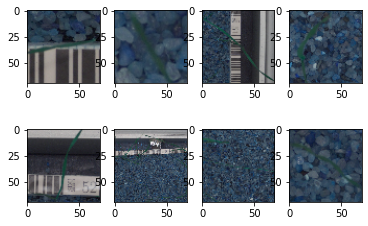

In [ ]:
# show some example images
for i in range(8):
  plt.subplot(2,4,i+1)
  plt.imshow(trainImg[i])

As we can see, every photo of plant seedling has an background, so let's try to remove it. It'll help us to goal better model accuracy

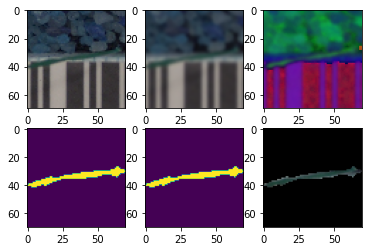

In [ ]:
clearTrainImg = []
examples = []; getEx = True
for img in trainImg:
  # Use gaussian blur
  blurImg = cv2.GaussianBlur(img, (5,5),0)

  # Convert to HSV image
  hsvImg = cv2.cvtColor(blurImg, cv2.COLOR_BGR2HSV)

  # Create mask (parameters - green color range)
  lower_green = (25, 40, 50)
  upper_green = (75, 255, 255)
  mask = cv2.inRange(hsvImg, lower_green, upper_green)
  kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(11,11))
  mask = cv2.morphologyEx(mask,cv2.MORPH_CLOSE,kernel)

  # Create bool mask
  bMask= mask >0

  # Apply the mask
  clear = np.zeros_like(img, np.uint8) # Create empty image
  clear[bMask] = img[bMask] #Apply boolean mask to the origin image
  clearTrainImg.append(clear) # Append image without background

  # Show examples
  if getEx:
    plt.subplot(2,3,1);plt.imshow(img) # show the original image
    plt.subplot(2,3,2);plt.imshow(blurImg) # show Blur image
    plt.subplot(2,3,3);plt.imshow(hsvImg) # show HSV image
    plt.subplot(2,3,4);plt.imshow(mask) # Mask
    plt.subplot(2,3,5);plt.imshow(bMask) # Boolean mask
    plt.subplot(2,3,6);plt.imshow(clear) # Image without background
    getEx = False

clearTrainImg = np.asarray(clearTrainImg)

Good result! Let's look at other examples of masked images

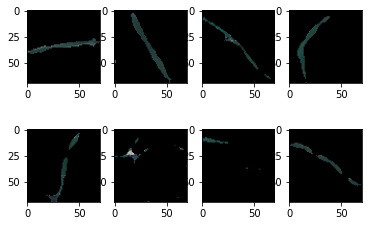

In [ ]:
# show sample results
for i in range(8):
  plt.subplot(2,4,i+1)
  plt.imshow(clearTrainImg[i])

As we can see, we removed most of the background.

### 2.2. Normalize input

Now set the values of input from [0...255] to [0...1] (RGB color-space encode colors with numbers [0...255]). CNN will be faster train if we use [0...1] input



In [ ]:
clearTrainImg = clearTrainImg /255

### 2.3. Categories labels

Now we encode image labels. Labels are 12 string names, so we could create classes array with this names, for example ['Black-grass' 'Charlock' 'Cleavers' 'Common Chickweed' 'Common wheat' 'Fat Hen' 'Loose Silky-bent' 'Maize' 'Scentless Mayweed' 'Shepherds Purse' 'Small-flowered Cranesbill' 'Sugar beet'] and encode every label by position in this array. For example 'Charlock' -> [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0].

We need to encode all labels in this way.

Classes:['Black-grass' 'Charlock' 'Cleavers' 'Common Chickweed' 'Common wheat'
 'Fat Hen' 'Loose Silky-bent' 'Maize' 'Scentless Mayweed'
 'Shepherds Purse' 'Small-flowered Cranesbill' 'Sugar beet']
Number of classes:12


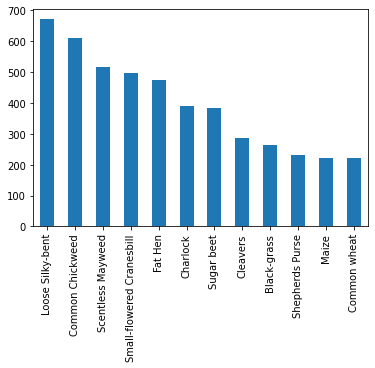

In [ ]:
from keras.utils import np_utils
from sklearn import preprocessing
import matplotlib.pyplot as plt

# encode labels and create classes
le = preprocessing.LabelEncoder()
le.fit(trainLabel[0])
print("Classes:" + str(le.classes_))
encodeTrainLabels = le.transform(trainLabel[0])

# Make labels categorical
clearTrainLabel = np_utils.to_categorical(encodeTrainLabels)
num_clases = clearTrainLabel.shape[1]
print("Number of classes:" + str(num_clases))

# Plot of label types numbers
trainLabel[0].value_counts().plot(kind='bar')

As we can see, we have different counts of images of different species. So, data is unbalanced

### 3. Model
#### 3.1. Split dataset

Split data on training and validation set. 10% of data became the validation set

Our data is unbalanced, so for avoide inaccurate evaluation of model set stratify=clearTrainLabel

In [ ]:
from sklearn.model_selection import train_test_split
trainX,testX,trainY, testY = train_test_split(clearTrainImg,clearTrainLabel,test_size=0.1,random_state=seed,stratify=clearTrainLabel)

#### 3.2. Data generator

To avoide overfitting we need to create image generator which will randomly rotate, zoom, shift and flip image during the fitting of the model.

* Set random rotation from 0 to 180 degrees
* Set random zoom at 0.1
* Set random shifting at 0.1
* Set horisontal and vertical flips

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(rotation_range=180, zoom_range = 0.1, width_shift_range=0.1,height_shift_range=0.1,horizontal_flip=True,vertical_flip=True)
datagen.fit(trainX)

#### 3.3. Create model

For creation model i used Keras Sequential.

I created model with six convolutional layers and three fully-connected layers in the end. First two convolutional layers have 64 filters, next 128 filters and the last two layers have 256 filters. After each pair of convolution layers model have max pooling layer. Also, to reduce overfitting after each pair of convolution layers we use dropout layer (10% between convolutional layers and 50% between fully connect layers) and between each layer we use batch normalization layer.

In the end i used three fully-connected layers for classifing. In the last layer the neural net outputs destribution of probability for each of 12 classes.

In [ ]:
import numpy
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import BatchNormalization

numpy.random.seed(seed) # Fix seed

model = Sequential()
model.add(Conv2D(filters=64,kernel_size=(5,5),input_shape=(ScaleTo, ScaleTo, 3),activation="relu"))
model.add(BatchNormalization(axis=3))
model.add(Conv2D(filters=64,kernel_size=(5,5),activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.1))

model.add(Conv2D(filters=128,kernel_size=(5,5),activation='relu'))
model.add(BatchNormalization(axis=3))
model.add(Conv2D(filters=128,kernel_size=(5,5),activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.1))

model.add(Conv2D(filters=256,kernel_size=(5,5),activation='relu'))
model.add(BatchNormalization(axis=3))
model.add(Conv2D(filters=256,kernel_size=(5,5),activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.1))

model.add(Flatten())

model.add(Dense(256,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(256,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(num_clases, activation='softmax'))
model.summary()

# Compile model
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 66, 66, 64)        4864      
_________________________________________________________________
batch_normalization (BatchNo (None, 66, 66, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 62, 64)        102464    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 31, 31, 64)        256       
_________________________________________________________________
dropout (Dropout)            (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 27, 27, 128)       2

#### 3.4. Fit model

Here we'll train our model. Firstly, we set several callbacks. First callback reduce model learning rate. With high learning rate model quiker is the convergance, however with high learning rate the model could fall into a local minimum. So, we will decreace the learning rate at the process of fitting. We will reduce learning rate if the accuracy is not improved after for three epoch. Other two callbacks save best and last weights of model.


In [ ]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger

# Learning rate reduction
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc,',
patience=3,
verbose=1,
factor=0.4,
min_lr=0.00001)

# checkpoint
filepath='drive/MyDrive/Colab Notebooks/Plant Seedling Classification Data/weights.best_{epoch:02d}-{val_acc:.2f}.hdf5'
checkpoint = ModelCheckpoint(filepath,monitor='val_acc',verbose=1,save_best_only=True,mode = 'max')
filepath = 'drive/MyDrive/Colab Notebooks/Plant Seedling Classification Data/weights.last_auto4.hdf5'
checkpoint_all = ModelCheckpoint(filepath,monitor='val_acc',verbose=1,save_best_only=False,mode='max')

# all callbacks
callbacks_list = [checkpoint, learning_rate_reduction,checkpoint_all]

In [ ]:
ls

drive/  sample_data/


#### 4.1. Load model from file

Here we load the weights of best-fitting model from file (i used kaggle dataset with weights of model, which i trained earlier). Also i load from Data.npz training and validation data sets, on which model was fitting for evaluating of model accuracy.

In [ ]:
model.load_weights('drive/MyDrive/Colab Notebooks/weights.best_17-0.96.hdf5')

data = np.load('drive/MyDrive/Colab Notebooks/Data.npz')
d = dict(zip(('trainX','testX','trainY','testY'),(data[k] for k in data)))
trainX = d['trainX']
testX = d['testX']
trainY = d['trainY']
testY = d['testY']

print(model.evaluate(trainX,trainY)) # Evaluate on train set
print(model.evaluate(testX, testY)) # Evaluate on test set

134/134 [==============================] - 9s 11ms/step - loss: 0.0014 - accuracy: 0.9991
[0.0014229717198759317, 0.999532163143158]
15/15 [==============================] - 0s 19ms/step - loss: 0.2750 - accuracy: 0.9621
[0.27501168847084045, 0.9621052742004395]


#### 4.2. Confusion matrix

A good way to look at model errors.

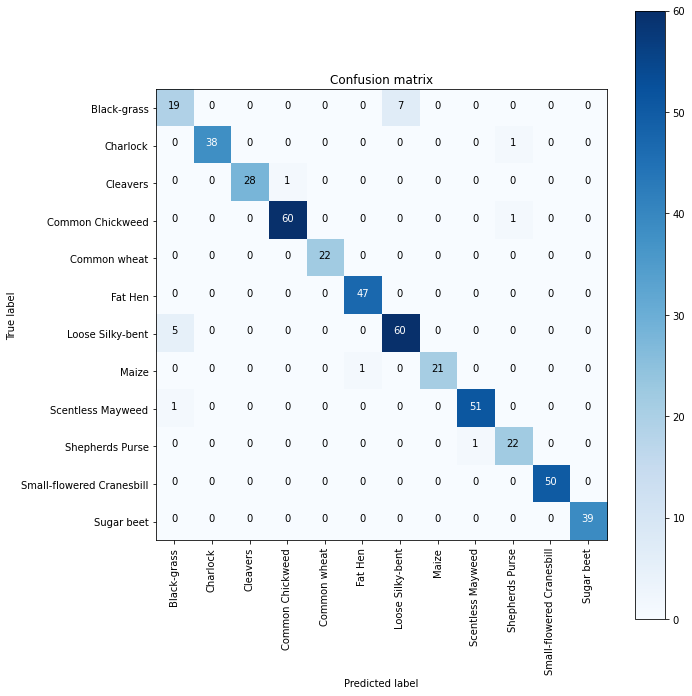

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    fig = plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
predY = model.predict(testX)
predYClasses = np.argmax(predY, axis = 1) 
trueY = np.argmax(testY, axis = 1) 

# confusion matrix
confusionMTX = confusion_matrix(trueY, predYClasses) 

# plot the confusion matrix
plot_confusion_matrix(confusionMTX, classes = le.classes_)

#### 4.3. Get results

And finnaly we get the result of prediction on test data.

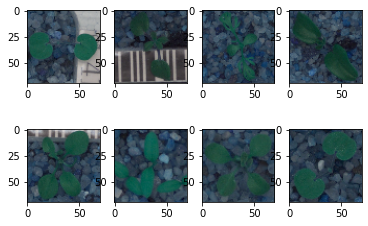

In [ ]:
path = '/content/drive/MyDrive/Colab Notebooks/Plant Seedling Classification Data/test/*.png'
files = glob(path)

testImg = []
testId = []
j = 1
num = len(files)

# Obtain images and resizing, obtain labels
for img in files:
  print("Obtain images:"+ str(j) + '/' + str(num), end = '\r')
  testId.append(img.split('/')[-1]) # Images id's
  testImg.append(cv2.resize(cv2.imread(img),(ScaleTo,ScaleTo)))
  j +=1

testImg = np.asarray(testImg) # Train images set

for i in range(8):
  plt.subplot(2,4,i+1)
  plt.imshow(testImg[i])

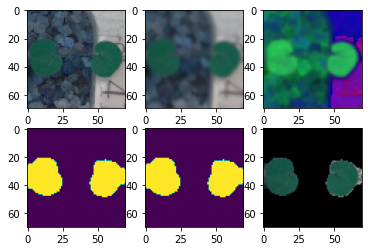

In [ ]:
clearTestImg = []
examples = []; getEx = True
for img in testImg:
  # Use gaussian blur
  blurImg = cv2.GaussianBlur(img,(5,5),0)
  # Convert to HSV Image
  hsvImg = cv2.cvtColor(blurImg, cv2.COLOR_BGR2HSV)

  # Create mask (parameter- green color range)
  lower_green = (25,40,50)
  upper_green = (75,255,255)
  mask = cv2.inRange(hsvImg, lower_green, upper_green)
  kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(11,11))
  mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE,kernel)

  # Create bool Mask
  bMask = mask > 0 

  # Apply the mask
  clear = np.zeros_like(img,np.uint8) # Create empty image
  clear[bMask] = img[bMask] # Apply boolean mask to the origin image
  clearTestImg.append(clear) # Append image without background

  # Show examples
  if getEx:
    plt.subplot(2,3,1);plt.imshow(img) # show the original image
    plt.subplot(2,3,2);plt.imshow(blurImg) # Blur image
    plt.subplot(2,3,3);plt.imshow(hsvImg) # HSV Image
    plt.subplot(2,3,4);plt.imshow(mask) # mask
    plt.subplot(2,3,5);plt.imshow(bMask) # Boolean Mask
    plt.subplot(2,3,6);plt.imshow(clear) # Image without background
    getEx = False

clearTestImg = np.asarray(clearTestImg)

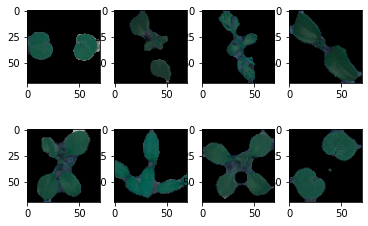

In [ ]:
for i in range(8):
  plt.subplot(2,4,i+1)
  plt.imshow(clearTestImg[i])

In [ ]:
clearTestImg = clearTestImg / 255


In [ ]:
pred = model.predict(clearTestImg)


In [ ]:
# Write result to file
predNum = np.argmax(pred, axis=1)
predStr = le.classes_[predNum]

res = {'file': testId, 'species': predStr}
res = pd.DataFrame(res)
res.to_csv('res.csv',index=False)

### SVM

In [ ]:
from keras.models import Model
model_feat = Model(inputs=model.input,outputs=model.get_layer('dense_1').output)

feat_train = model_feat.predict(trainX)
print(feat_train.shape)

feat_val = model_feat.predict(testX)
print(feat_val.shape)

feat_test = model_feat.predict(clearTestImg)
print(feat_test.shape)






(4275, 256)
(475, 256)
(794, 256)


In [ ]:
from sklearn import svm
clr = svm.SVC(kernel='rbf')
clr.fit(feat_train,np.argmax(trainY,axis=1))

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
# Prediction Score [Training Features]
clr.score(feat_train,np.argmax(trainY,axis=1))

0.9992982456140351

In [ ]:
#Prediction Score[Validation Features]
clr.score(feat_val,np.argmax(testY,axis=1))

0.9621052631578947

In [ ]:
# Predict on [Test Festures]
Pred_labels = clr.predict(feat_test)

# Part 2

**Explain in depth why CNN out performs neural networks which in turn out perform supervised learning models when it comes to image classification.**

* CNNs are used for image classification and recognition because of its high accuracy as we can see SVM given kernel rbf accuracy score is 96 and CNN gives Accuracy Score of 96 using regular convolution and dropouts.
* CNN Models can be trained to give best performance matrix. These models are highly valued for Image Detection, classification, recognition.
* CNN models has the sequence of creating their own trainable parameters thus giving them the advantage to create parameters.


# Part 3

## Automobile

A brand research company wants to understand which cars or car manufacturers are popular in a
certain area of the city or locality. Company has a team which takes pictures of the cars randomly through the day. Using this the company wants to set up an automation which can classify the make of the car once the picture has been given as an input.

In [2]:
import tensorflow
tensorflow.__version__

'2.4.1'

In [3]:
import random
random.seed(7)

import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [4]:
import cv2
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import skimage.io as io


ScaleTo = 400
path = '/content/drive/MyDrive/Colab Notebooks/Cars Images/*.jpg'

files = glob(path)
trainImg = []
trainLabel = []
j=1
num = len(files)

# Obtain images and resizing
for img in files:
  print(str(j) + '/' + str(num), end='\r')
  trainImg.append(cv2.resize(cv2.imread(img),(ScaleTo,ScaleTo))) # get image ( with resizing)
  trainLabel.append(img.split('/')[-1])
  j +=1
trainImg= np.asarray(trainImg) # train Images set
trainLabel = pd.DataFrame(trainLabel) #Train label set

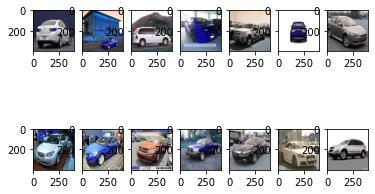

In [ ]:
for i in range(14):
  plt.subplot(2,7,i+1)
  plt.imshow(trainImg[i])

In [ ]:
import pandas as pd
df = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Cars Images/Part3 -Cars_Annotations.xlsx')
df.head()

,No.,Image,Color,Make
0,1,00001.jpg,White,Audi
1,2,00002.jpg,Black.,Acura
2,3,00003.jpg,Red,Dodge
3,4,00004.jpg,Red,Hyundai
4,5,00005.jpg,White,Ford


In [ ]:
trainLabel.sort_values(by=[0],inplace=True)
trainLabel.head()
# As the columns has no name

,0
12,00001.jpg
11,00002.jpg
10,00003.jpg
5,00004.jpg
4,00005.jpg


In [ ]:
# Renaming the columns
trainLabels = np.asarray(trainLabel)
columns = ['Image']
trainLabel_new=pd.DataFrame(trainLabels,columns=columns)

## Challenges Faced during execution of Dataset
* Car images being just one image
* Identify the Car in the image
* Boundry boxing at the logo of car
* Identify car based on logo
* Identify car based on color

Image sengmentation can also be used to identify the edges of car giving possiblity to know the name of car.

# Part 4

## Botanical research

• **CONTEXT:**  University X is currently undergoing some research involving understanding the characteristics of
flowers. They already have have invested on curating sample images. They require an automation which can
create a classifier capable of determining a flower’s species from a photo

• **DATA DESCRIPTION:** The dataset comprises of images from 17 plant species.

• **PROJECT OBJECTIVE:** Company’s management requires an automation which can create a classifier capable of
determining a flower’s species from a photo

In [ ]:
import pandas as pd
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob

In [ ]:
import cv2
path = '/content/drive/MyDrive/Colab Notebooks/Flowers - Classification/17flowers- train/jpg/*/*.jpg'
files = glob(path)
ScaleTo = 80

trainImg = []
trainLabel = []
category = []
j = 1
num = len(files)

for img in files:
  print(str(j) + '/' + str(num),end='\r')
  trainImg.append(cv2.resize(cv2.imread(img),(ScaleTo,ScaleTo)))
  trainLabel.append(img.split('/')[-1])
  category.append(img.split('/')[-2])
  j +=1

trainImg = np.asarray(trainImg)
trainLabel = pd.DataFrame(trainLabel)
category = pd.DataFrame(category)

### Framing the stucture to classify images of flowers based on different classes.

In [ ]:
columns = ['Labels']
category.sort_values(by=[0],inplace=True)
category = np.asarray(category)
category = pd.DataFrame(category,columns = columns)
category

,Labels
0,0
1,0
2,0
3,0
4,0
...,...
1370,9
1371,9
1372,9
1373,9


In [ ]:
columns = ['Image']
trainLabel.sort_values(by=[0],inplace=True)
trainLabel = np.asarray(trainLabel)
trainLabel = pd.DataFrame(trainLabel,columns = columns)
trainLabel

,Image
0,image_0001.jpg
1,image_0002.jpg
2,image_0003.jpg
3,image_0004.jpg
4,image_0005.jpg
...,...
1370,image_1356.jpg
1371,image_1357.jpg
1372,image_1358.jpg
1373,image_1359.jpg


In [ ]:
# join category and Labels
df=category.join(trainLabel)

In [ ]:
df.head()

,Labels,Image
0,0,image_0001.jpg
1,0,image_0002.jpg
2,0,image_0003.jpg
3,0,image_0004.jpg
4,0,image_0005.jpg


### Print Images to see the flowers and their classified classes.

In [ ]:
import os
import tarfile
PATH = '/content/drive/MyDrive/Colab Notebooks/Flower_Classification/'
DATA_PATH = '/content/drive/MyDrive/Colab Notebooks/Flowers - Classification/17flowers- train/'
opened_tgz = tarfile.open(DATA_PATH + "17flowers.tgz")
opened_tgz.extractall(PATH)

# Check the files
print(os.listdir(PATH + 'jpg')[:12])

['image_0901.jpg', 'image_0902.jpg', 'image_0903.jpg', 'image_0907.jpg', 'image_0904.jpg', 'image_0909.jpg', 'image_0908.jpg', 'image_0905.jpg', 'image_0910.jpg', 'image_0906.jpg', 'image_0912.jpg', 'image_0911.jpg']


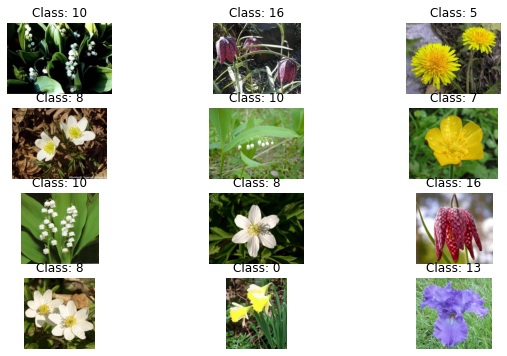

In [ ]:
# Example of the images that dataset contains
import PIL
from PIL import ImageOps, ImageFilter
plt.figure(figsize = (10, 6))

random_image = df.sample(n = 12)
random_image_paths = random_image['Image'].values
random_image_category = random_image['Labels'].values

for index,path in enumerate(random_image_paths):
    ax = PIL.Image.open(PATH+'/jpg/'+ path)
    plt.subplot(4, 3, index + 1)
    plt.imshow(ax)
    plt.title("Class: " + str(random_image_category[index]))
    plt.axis("off")

plt.show();

### Spliting the data into train and test split using sklearn

In [ ]:
# train/test splitting
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df['Image'], df['Labels'], test_size = 0.2, stratify = df['Labels'])

X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

X_train['Labels'] = y_train
X_test['Labels'] = y_test

print(f"Shape of the Train Data: {X_train.shape}\nShape of the Test Data: {X_test.shape}")

Shape of the Train Data: (1100, 2)
Shape of the Test Data: (275, 2)


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1. /255,
                                   rotation_range= 50,
                                   shear_range=0.2,
                                   zoom_range = [0.75,1.25],
                                   brightness_range = [0.5,1.5],
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
# Wrapping all data to the generator
IMG_SIZE = 128
BATCH_SIZE = 128


In [ ]:
# Wrapping all data to the generator
train_generator = train_datagen.flow_from_dataframe(dataframe = X_train, directory = PATH+'/jpg', x_col = 'Image', y_col = "Labels",
                                                    target_size = (IMG_SIZE, IMG_SIZE), batch_size = BATCH_SIZE, class_mode = 'categorical',
                                                    shuffle = True, seed = 42)

test_generator = test_datagen.flow_from_dataframe(dataframe = X_test, directory = PATH+'/jpg', x_col = 'Image', y_col = "Labels", 
                                                  target_size = (IMG_SIZE, IMG_SIZE), batch_size = BATCH_SIZE, class_mode = 'categorical',
                                                 shuffle = False, seed = 42)

Found 1088 validated image filenames belonging to 17 classes.
Found 272 validated image filenames belonging to 17 classes.


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 12 invalid image filename(s) in x_col="Image". These filename(s) will be ignored.
  .format(n_invalid, x_col)
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 3 invalid image filename(s) in x_col="Image". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Image Train example:


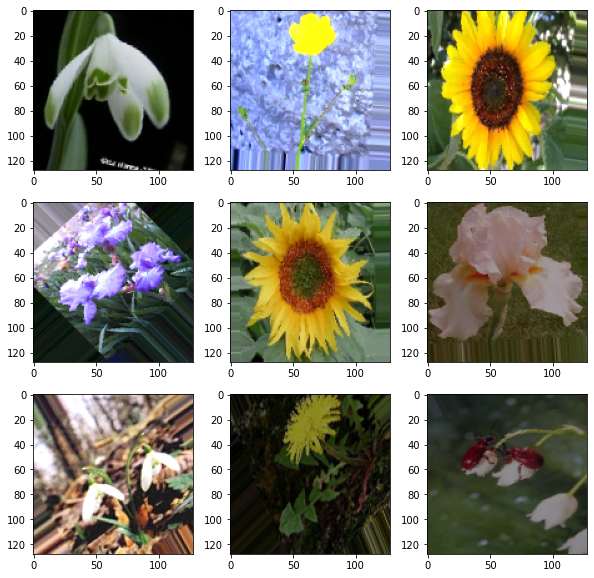

In [ ]:
from skimage import io

def imshow(image):
    io.imshow(image)
    io.show()
    
x, y = train_generator.next()
print("Image Train example:")
plt.figure(figsize = (10, 10))

for i in range(0, 9):
    image = x[i]
    plt.subplot(3, 3, i + 1)
    plt.imshow(image)

plt.show();

In [ ]:
X_test_gen, y_test_gen = test_generator.next()
y_test_gen.shape

(16, 17)

In [ ]:
# All the main settings for NN will be listed below for convinient

EPOCHS = 10
BATCH_SIZE = 128
LR = 1e-3
VAL_SPLIT = 0.2

CLASS_NUM = 17
IMG_SIZE = 128
IMG_CHANNELS = 3
input_shape = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

In [ ]:
# print input shape
input_shape

(128, 128, 3)

#### Loading tensorflow libraries

In [ ]:
 # Neural Network frameworks
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.models as M
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
import tensorflow.keras.callbacks as C
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping, Callback
#from tensorflow.keras.regularizers import l2
#from tensorflow.applications.inception_v3 import Inception_v3
from tensorflow.keras import optimizers

In [ ]:
model = M.Sequential()

# model's Layer[1]
model.add(L.Convolution2D(128, (3, 3), input_shape = input_shape, activation = 'elu', padding = 'same',))
model.add(L.BatchNormalization())
model.add(L.Convolution2D(128, (3, 3), input_shape = input_shape, activation = 'elu', padding = 'same',))
model.add(L.BatchNormalization())

# Pooling for the model's Layer[1]
model.add(L.MaxPooling2D(pool_size = (2, 2)))
model.add(L.Dropout(0.2))

# model's Layer[2]
model.add(L.Convolution2D(256, (3, 3), activation = 'elu', padding = 'same',))
model.add(L.BatchNormalization())
model.add(L.Convolution2D(256, (3, 3), activation = 'elu', padding = 'same',))
model.add(L.BatchNormalization())

# Pooling for the model's Layer[2]
model.add(L.MaxPooling2D(pool_size = (2, 2)))
model.add(L.Dropout(0.3))

# model's Layer[3]
model.add(L.Convolution2D(512, (3, 3), activation = 'elu', padding = 'same'))
model.add(L.BatchNormalization())
model.add(L.Convolution2D(512, (3, 3), activation = 'elu', padding = 'same'))
model.add(L.BatchNormalization())

# Pooling for the model's Layer[3]
model.add(L.MaxPooling2D(pool_size = (2, 2)))
model.add(L.Dropout(0.3))



# Flattening the output data after convolution and pooling. The Data comes from the last 3rd layer
model.add(L.Flatten())

# Adding Fully Connected Layer
model.add(L.Dense(512, activation = 'elu'))
model.add(L.Dropout(0.25))
model.add(L.Dense(CLASS_NUM, activation = 'softmax'))

#### Show the summary of the model

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 128)     3584      
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 128)     512       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 128)     147584    
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 128)     512       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 256)       2

### Model Training

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer=optimizers.Adamax(lr=LR),metrics=['accuracy'])

In [ ]:
checkpoint = ModelCheckpoint('best_model.hdf5', monitor = ['val_accuracy'], verbose = 1, mode = 'max')
earlystop = EarlyStopping(monitor = 'val_accuracy', patience = 5, restore_best_weights = True)
callbacks_list = [checkpoint, earlystop]

In [ ]:
scores = model.evaluate_generator(test_generator, steps = 1, verbose = 1)
print("Accuracy: %.2f%%" % (scores[1] * 100))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


1/1 [==============================] - 35s 35s/step - loss: 2.8248 - accuracy: 0.0625
Accuracy: 6.25%


In [ ]:
# Training
history = model.fit_generator(train_generator, 
                              steps_per_epoch = train_generator.samples // train_generator.batch_size,
                              validation_data = test_generator,
                              validation_steps= test_generator.samples//test_generator.batch_size,
                              epochs = 2,
                              callbacks = callbacks_list)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/2
8/8 [==============================] - 1058s 133s/step - loss: 74.0577 - accuracy: 0.1323 - val_loss: 320.7474 - val_accuracy: 0.1680

Epoch 00001: saving model to best_model.hdf5
Epoch 2/2
8/8 [==============================] - 1052s 133s/step - loss: 29.9434 - accuracy: 0.2324 - val_loss: 294.5461 - val_accuracy: 0.0977

Epoch 00002: saving model to best_model.hdf5


## Transfer Learning

In [ ]:
base_model = tf.keras.applications.ResNet50V2(weights='imagenet',include_top=False,input_shape=input_shape)

94674944/94668760 [==============================] - 3s 0us/step


In [ ]:
## summary of base model
base_model.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 66, 66, 64)   0           conv1_conv[0][0]                 
_________________________________________________________________________________________

In [ ]:
model = M.Sequential()
model.add(base_model)
model.add(L.GlobalAveragePooling2D(),)
model.add(L.Dense(CLASS_NUM,activation='softmax'))

In [ ]:
# Summary of model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 4, 4, 2048)        23564800  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 17)                34833     
Total params: 23,599,633
Trainable params: 23,554,193
Non-trainable params: 45,440
_________________________________________________________________


In [ ]:
model.compile(loss='categorical_crossentropy',optimizer=optimizers.Adamax(lr=LR),metrics=['accuracy'])

In [ ]:
checkpoint = ModelCheckpoint('best_model.hdf5',monitor=['val_accuracy'],verbose=1,mode='max')
earlystop = EarlyStopping(monitor='val_accuracy',patience=5,restore_best_weights=True)
callbacks_list = [checkpoint,earlystop]

In [ ]:
scores = model.evaluate_generator(test_generator,steps=1,verbose=1)
print("Accuracy: %.2f%%" %(scores[1]*100))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


1/1 [==============================] - 9s 9s/step - loss: 3.9552 - accuracy: 0.0781
Accuracy: 7.81%


In [ ]:
history = model.fit_generator(train_generator,
                              steps_per_epoch = train_generator.samples//train_generator.batch_size,
                              validation_data = test_generator,
                              validation_steps = test_generator.samples//test_generator.batch_size,
                              epochs=10,
                              callbacks=callbacks_list)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
8/8 [==============================] - 281s 34s/step - loss: 2.0109 - accuracy: 0.4292 - val_loss: 5.4978 - val_accuracy: 0.3672

Epoch 00001: saving model to best_model.hdf5
Epoch 2/10
8/8 [==============================] - 256s 31s/step - loss: 1.0532 - accuracy: 0.6656 - val_loss: 4.2871 - val_accuracy: 0.3867

Epoch 00002: saving model to best_model.hdf5
Epoch 3/10
8/8 [==============================] - 253s 31s/step - loss: 0.7145 - accuracy: 0.7740 - val_loss: 4.0012 - val_accuracy: 0.5078

Epoch 00003: saving model to best_model.hdf5
Epoch 4/10
8/8 [==============================] - 251s 31s/step - loss: 0.5133 - accuracy: 0.8333 - val_loss: 2.8554 - val_accuracy: 0.5742

Epoch 00004: saving model to best_model.hdf5
Epoch 5/10
8/8 [==============================] - 244s 30s/step - loss: 0.4279 - accuracy: 0.8667 - val_loss: 2.5857 - val_accuracy: 0.5547

Epoch 00005: saving model to best_model.hdf5
Epoch 6/10
8/8 [==============================] - 254s 34s/step - loss

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/Flower_Classification')
model.load_weights('best_model.hdf5')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/Flower_Classification/assets


In [ ]:
scores = model.evaluate_generator(test_generator,steps=1,verbose=1)
print("Accuracy: %.2f%%" %(scores[1]*100))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


1/1 [==============================] - 6s 6s/step - loss: 1.3723 - accuracy: 0.6953
Accuracy: 69.53%


In [ ]:
def plot_history(history):
    plt.figure(figsize = (10, 5))
    plt.style.use('dark_background')
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(len(acc))
    
    plt.plot(epochs, acc, 'b', label = 'Training accuracy')
    plt.plot(epochs, val_acc, 'r', label = 'Validation accuracy')
    plt.title("Training and validation accuracy")
    plt.legend()
    
    
    plt.figure(figsize = (10,5))
    plt.style.use('dark_background')
    plt.plot(epochs, loss, 'b', label = 'Training loss')
    plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
    plt.title('Training and Validation loss')
    plt.legend()
    
    plt.show()

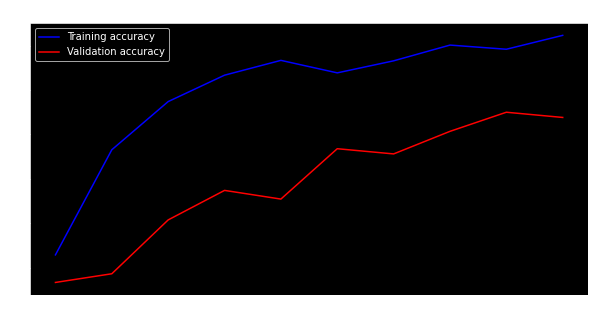

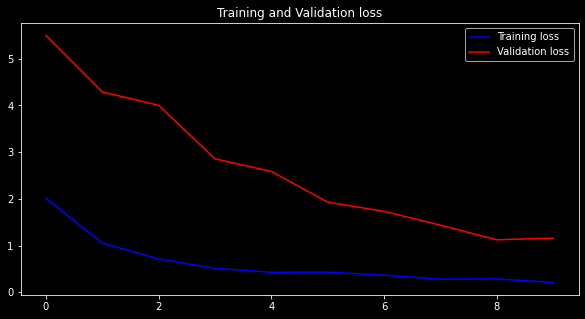

In [ ]:
plot_history(history)

## Transfer Learning with freezing weights

In [ ]:
model = M.Sequential()
model.add(base_model)
model.add(L.GlobalAveragePooling2D(),)
model.add(L.Dense(CLASS_NUM,activation='softmax'))

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 4, 4, 2048)        23564800  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 17)                34833     
Total params: 23,599,633
Trainable params: 23,554,193
Non-trainable params: 45,440
_________________________________________________________________


In [ ]:
len(model.trainable_variables)

174

In [ ]:
# Check the trainable status of the individual layers
for i in model.layers:
  print(i,i.trainable)

<tensorflow.python.keras.engine.functional.Functional object at 0x7f80351edda0> True
<tensorflow.python.keras.layers.pooling.GlobalAveragePooling2D object at 0x7f8031aac0f0> True
<tensorflow.python.keras.layers.core.Dense object at 0x7f80330db2b0> True


In [ ]:
LR = 0.001
model.compile(loss = 'categorical_crossentropy', optimizer = optimizers.Adamax(lr = LR), metrics = ['accuracy'])
checkpoint = ModelCheckpoint('best_model.hdf5', monitor = ['val_accuracy'], verbose = 1, mode = 'max')
earlystop = EarlyStopping(monitor = 'val_accuracy', patience = 5, restore_best_weights = True)
callbacks_list = [checkpoint, earlystop]

In [ ]:
scores = model.evaluate_generator(test_generator, steps = 1, verbose = 1)
print("Accuracy: %.2f%%" % (scores[1] * 100))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


1/1 [==============================] - 7s 7s/step - loss: 3.9719 - accuracy: 0.0859
Accuracy: 8.59%


In [ ]:
history = model.fit_generator(train_generator,
                              steps_per_epoch = train_generator.samples // train_generator.batch_size,
                              validation_data = test_generator, 
                              validation_steps= test_generator.samples // test_generator.batch_size,
                              epochs = 15,
                              callbacks = callbacks_list)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
8/8 [==============================] - 268s 33s/step - loss: 1.1988 - accuracy: 0.6542 - val_loss: 2.8691 - val_accuracy: 0.5078

Epoch 00001: saving model to best_model.hdf5
Epoch 2/15
8/8 [==============================] - 253s 31s/step - loss: 0.6061 - accuracy: 0.7969 - val_loss: 2.6922 - val_accuracy: 0.6367

Epoch 00002: saving model to best_model.hdf5
Epoch 3/15
8/8 [==============================] - 277s 35s/step - loss: 0.4967 - accuracy: 0.8479 - val_loss: 3.1469 - val_accuracy: 0.5664

Epoch 00003: saving model to best_model.hdf5
Epoch 4/15
8/8 [==============================] - 268s 34s/step - loss: 0.4129 - accuracy: 0.8521 - val_loss: 1.5371 - val_accuracy: 0.6172

Epoch 00004: saving model to best_model.hdf5
Epoch 5/15
8/8 [==============================] - 254s 31s/step - loss: 0.3499 - accuracy: 0.8750 - val_loss: 2.2356 - val_accuracy: 0.5898

Epoch 00005: saving model to best_model.hdf5
Epoch 6/15
8/8 [==============================] - 245s 29s/step - loss

In [ ]:
# Number of layers in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  190


In [ ]:
base_model.trainable = True

# fine tune from this layers to the end
fine_tune_at = 100

# freeze all other layers before the fine_tune_at layer:
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

print(f"The number of trainable vars: {len(base_model.trainable_variables)}")

The number of trainable vars: 82


In [ ]:
LR = 0.0001

model.compile(loss = 'categorical_crossentropy', optimizer = optimizers.Adamax(lr = LR), metrics = ['accuracy'])
checkpoint = ModelCheckpoint('best_model.hdf5', monitor = ['val_accuracy'], verbose = 1, mode = 'max')
earlystop = EarlyStopping(monitor = 'val_accuracy', patience = 5, restore_best_weights = True)
callbacks_list = [checkpoint, earlystop]

In [ ]:
scores = model.evaluate_generator(test_generator, steps = 1, verbose = 1)
print("Accuracy: %.2f%%" % (scores[1] * 100))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


1/1 [==============================] - 7s 7s/step - loss: 2.7645 - accuracy: 0.6016
Accuracy: 60.16%


In [ ]:
history = model.fit_generator(train_generator,
                              steps_per_epoch = train_generator.samples // train_generator.batch_size,
                              validation_data = test_generator, 
                              validation_steps= test_generator.samples // test_generator.batch_size,
                              epochs = 15,
                              callbacks = callbacks_list)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
8/8 [==============================] - 166s 20s/step - loss: 0.5701 - accuracy: 0.8000 - val_loss: 1.7423 - val_accuracy: 0.6914

Epoch 00001: saving model to best_model.hdf5
Epoch 2/15
8/8 [==============================] - 159s 20s/step - loss: 0.4045 - accuracy: 0.8552 - val_loss: 1.3921 - val_accuracy: 0.7109

Epoch 00002: saving model to best_model.hdf5
Epoch 3/15
8/8 [==============================] - 169s 22s/step - loss: 0.3655 - accuracy: 0.8677 - val_loss: 1.1603 - val_accuracy: 0.7461

Epoch 00003: saving model to best_model.hdf5
Epoch 4/15
8/8 [==============================] - 169s 21s/step - loss: 0.3542 - accuracy: 0.8656 - val_loss: 0.9850 - val_accuracy: 0.7500

Epoch 00004: saving model to best_model.hdf5
Epoch 5/15
8/8 [==============================] - 175s 21s/step - loss: 0.3211 - accuracy: 0.8885 - val_loss: 0.8824 - val_accuracy: 0.7695

Epoch 00005: saving model to best_model.hdf5
Epoch 6/15
8/8 [==============================] - 168s 22s/step - loss

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/Flower_Classification/jpg')
model.load_weights('best_model.hdf5')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/Flower_Classification/jpg/assets


In [ ]:
scores = model.evaluate_generator(test_generator, steps = 1, verbose = 1)
print("Accuracy: %.2f%%" % (scores[1] * 100))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


1/1 [==============================] - 6s 6s/step - loss: 0.6976 - accuracy: 0.7891
Accuracy: 78.91%


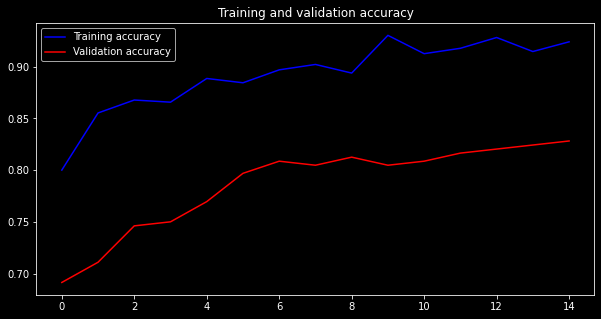

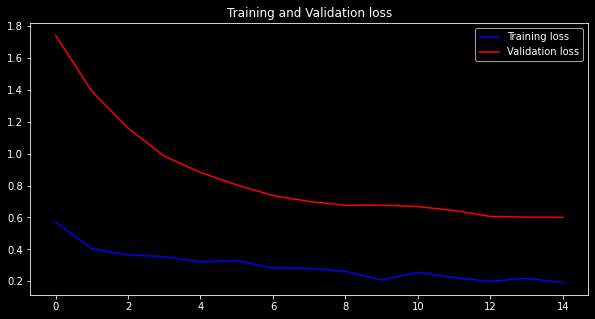

In [ ]:
plot_history(history)

### Supervised Learning Models(SVM)

In [ ]:
from keras.models import Model
model_feat = Model(inputs=model.input,outputs=model.get_layer('dense_1').output)

feat_train = model_feat.predict(x)
print(feat_train.shape)

# feat_val = model_feat.predict(y)
# print(feat_val.shape)

feat_test = model_feat.predict(X_test_gen)
print(feat_test.shape)

(128, 17)
(16, 17)


In [ ]:
from sklearn import svm
clr = svm.SVC(kernel='rbf')
clr.fit(feat_train,y_train[:128])

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
# Prediction Score [Training Features]
clr.score(feat_train,y_train[:128])

0.2265625

As we can see the SVM model performs poorly for the training test set.

### **GUI Interface Classification**

In [ ]:
from tkinter import *
import tkinter.filedialog
from PIL import ImageTk, Image
root = Tk()
canvas = Canvas(root, width = 300, height = 300)
def Import():
    global f
    
    f = tkinter.filedialog.askopenfilename(
        parent=root, initialdir='/',
        title = 'Choose File',
        filetypes = [('png images','.png'),
                     ('gif images','.gif')]
        )
    print(f)
    img_file = ImageTk.PhotoImage(Image.open(f))
    myLabel4 = Label(image = img_file)
    myLabel4.grid(row=4,column=2)
    
    
# Predict the data
def Predict():
    
    return

root.title('Classifier GUI')
myLabel1 = Label(root,text='Step 1:')
myLabel2 = Label(root,text ='File Name')
myLabel3 = Label(root,text = 'Image Classifier')
e = Entry(root,width=25,borderwidth=3)
myButton1 = Button(root,text='Import Data',command=Import)
myButton2 = Button(root,text='Predict',command=Predict)




myLabel1.grid(row=0,column=0,columnspan=1)
myLabel2.grid(row=0,column=1)
myLabel3.grid(row=1,column=1)
e.grid(row=0,column=2)
myButton1.grid(row=0,column=3)
myButton2.grid(row=3,column=2)
root.mainloop()


# Part 5

**Explain in depth your strategy to maintain and support the AIML image classifier after it in production.**


Entering into the details:

*   First we saw the Plant Seedling distributions, their Kinds: 'Black-grass' 'Charlock' 'Cleavers' 'Common Chickweed' 'Common wheat'
 'Fat Hen' 'Loose Silky-bent' 'Maize' 'Scentless Mayweed'
 'Shepherds Purse' 'Small-flowered Cranesbill' 'Sugar beet'. Identifying the plant Image and classification of Image based on classes using SVM, CNN model. Predicted the output based on Plant image.
*   Secondly, looked into CNN Model and how it out performed every other model such as supervised learning model such as svm.
*   Looking towards Automobile domain, we saw different car Images, and their categories. Identifying the Car Image into their Brand type was the Challenge. Came forward the idea of building Image classifier to identify Car images based on their color, logos, shape etc.
*   Study into sets of Flower Images. Image Categories into classes and predict which class the flower belongs to. Using the model such as svm, CNN, R-CNN for training the model to get best validation accuracy.Creating a GUI for importing and predicting the class of the Image.
*   Model getting into the production to classify different Flowers. To study the how much varities of flowers and make human to identify them easily. Suppose Google photos wants to see which Photo of flower is uploaded from the device and help the user to allocate the data ones the user wants particular flower photos next time. This consumes both Time and accessing of object in order to find it quickly.









